<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DBSCAN Practice

---

You're now familiar with how DBSCAN works. Let's practice it in sklearn.

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import cluster
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist, squareform

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Fit DBSCAN on a generated dataset


We will start with a simple generated dataset. 

Import the `make_circles` function from `sklearn.datasets`. You can use this to generate some clusters that will perform well with DBSCAN.

Create some `X` and `y` using the function. Here is some sample code:
```python
from sklearn.datasets import make_circles
circles_X, circles_y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
```

### 1. Plot the generated circles data

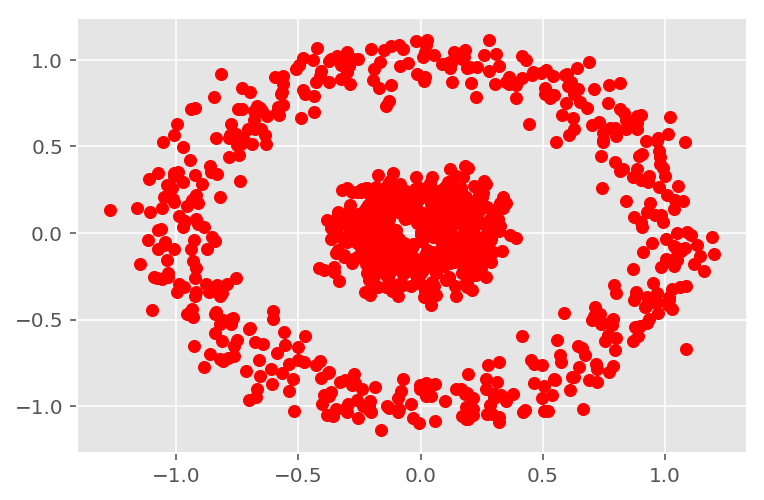

In [2]:
from sklearn.datasets import make_circles

circles_X, circles_y = make_circles(
    n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(circles_X[:, 0], circles_X[:, 1], c='r')
plt.show()

### 2. Rescale the data

In [3]:
scaler = StandardScaler()
X = scaler.fit_transform(circles_X)

In [4]:
X.shape

(1000, 2)

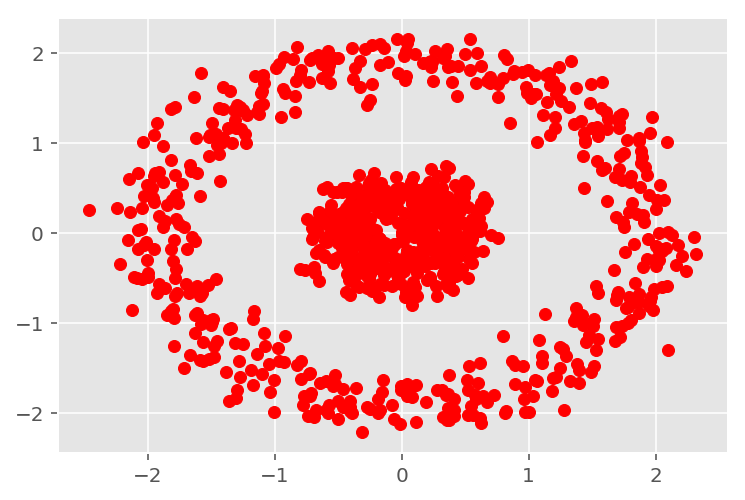

In [5]:
plt.scatter(X[:, 0], X[:, 1], c='r')
plt.show()

### 3. Fit DBSCAN on the rescaled data

In [6]:
dbscan = DBSCAN(eps=.5, min_samples=3)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=1, p=None)

### 4. Extract the cluster labels.

In [7]:
labels = dbscan.labels_
print(np.unique(labels))
print(len(labels), labels.sum())

[0 1]
1000 500


### 5. How many clusters do you get?

In [8]:
n_clusters_ = len(set(labels) - set([-1]))
print(n_clusters_)

2


### 6. Evaluate DBSCAN

- Visually
- With silhouette score
- Using the true `y`, with homogeneity, completeness and V-measure score

In [9]:
def cluster_score(X, y, labels):
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))
    print('Estimated number of clusters: %d' % n_clusters_)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))

In [10]:
cluster_score(X, circles_y, labels)

Silhouette Coefficient: 0.238
Estimated number of clusters: 2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000


### 7.  Extract the core samples. 

How many do you have?

In [11]:
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
# all samples are core samples
print(core_samples.sum())

1000


### 8. Create a scatter plot of the data with coloring according to the cluster labels

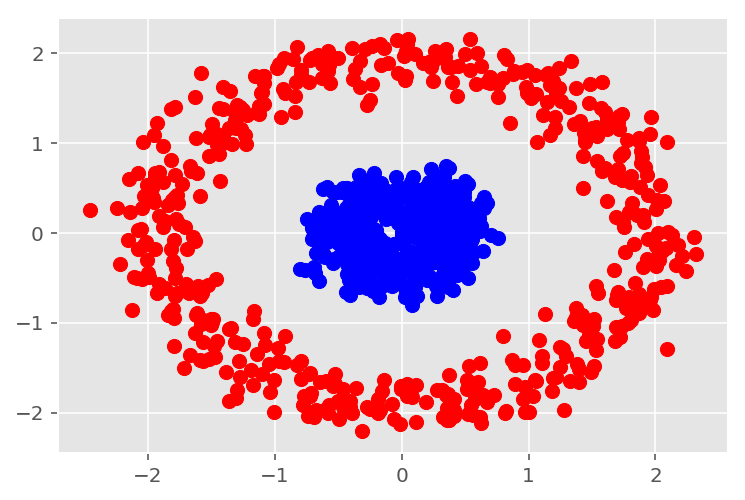

In [12]:
unique_labels = np.unique(labels)
colors = 'rb'

for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    n = X[class_member_mask & core_samples]
    plt.scatter(n[:, 0], n[:, 1], c=color, s=50)

    n = X[class_member_mask & ~core_samples]
    plt.scatter(n[:, 0], n[:, 1], c=color, s=50, marker='+')

DBSCAN performs perfectly in this case! When we have anisotropically or circularly 
plotted data, we should opt for DBSCAN because KMEANS has a number of 
assumptions (http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html) 
that often don't work out.

## Bonus:

## Try k-means and hierarchical clustering on the given datasets. Which differences do you observe? Which algorithm do you find most suitable in each case?

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering

### Standard k-means

Silhouette Coefficient: 0.264
Estimated number of clusters: 2
Homogeneity: -0.000
Completeness: -0.000
V-measure: -0.000


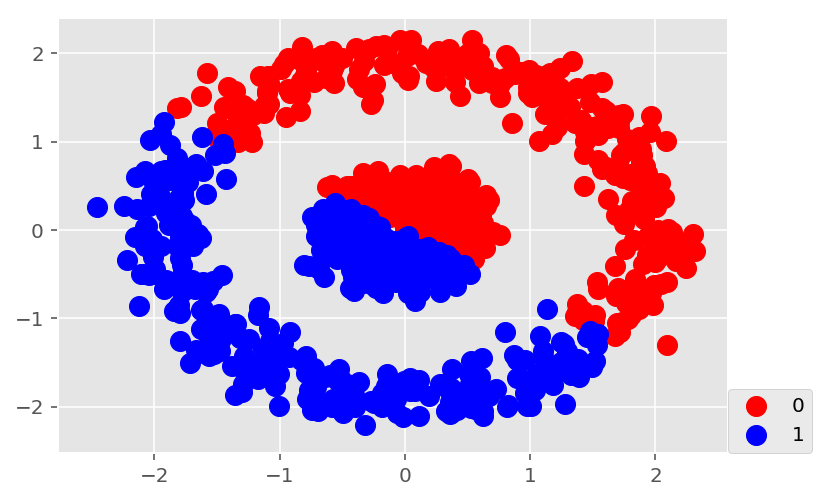

In [14]:
k_means = KMeans(n_clusters=2)
k_means.fit(X)
labels = k_means.labels_
cluster_score(X, circles_y, labels)

# how many clusters do we have?
n_clusters_ = len(set(labels))

unique_labels = np.unique(labels)
colors = 'rbgymko'

for (label, color) in zip(unique_labels, colors):

    class_member_mask = (labels == label)
    n = X[class_member_mask, :]
    plt.scatter(n[:, 0], n[:, 1], c=color, s=100, label=label)
    plt.legend(loc=[1, 0])

### Standard hierarchical clustering

Silhouette Coefficient: 0.381
Estimated number of clusters: 2
Homogeneity: 0.216
Completeness: 0.312
V-measure: 0.255


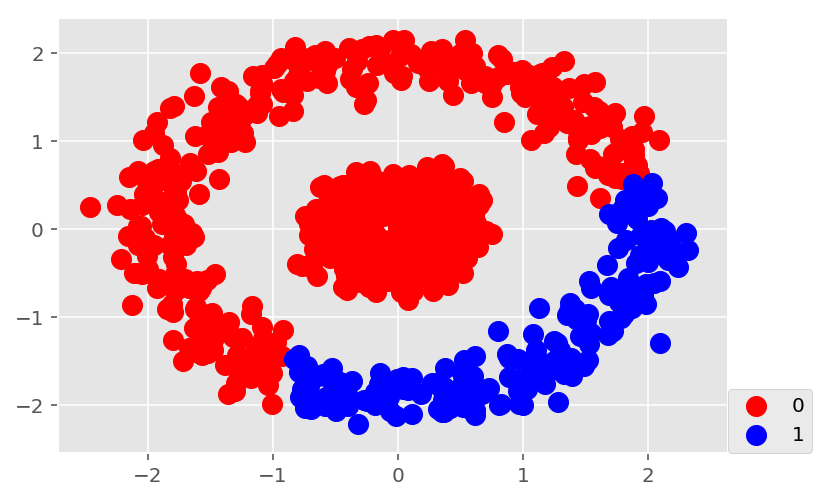

In [15]:
agg = AgglomerativeClustering(n_clusters=2)
agg.fit(X)
labels = agg.labels_
cluster_score(X, circles_y, labels)

unique_labels = np.unique(labels)
colors = 'rbgymko'

for (label, color) in zip(unique_labels, colors):

    class_member_mask = (labels == label)
    n = X[class_member_mask, :]
    plt.scatter(n[:, 0], n[:, 1], c=color, s=100, label=label)
    plt.legend(loc=[1, 0])

### Transform to polar coordinates

Instead of Cartesian x and y coordinates, we can use radial distance from the center and the polar angle (the angle between the x-axis and the vector pointing to any given point).

The relations are

$$
\begin{eqnarray*}
x &=& r \cos \phi\\
y &=& r \sin \phi\\
r &=& \sqrt{x^2+y^2}\\
\phi &=& \left\{
\begin{array}{c}
\tan^{-1}\frac{y}{x}\ {\rm if } x>0 \\
\tan^{-1}\frac{y}{x}+\pi\ {\rm if }\ x<0 \ {\rm and}\ y>0 \\
\tan^{-1}\frac{y}{x}-\pi\ {\rm if }\ x<0 \ {\rm and}\ y<0\\
\frac{\pi}{2}\ {\rm if }\ x=0 \ {\rm and}\ y>0 \\
-\frac{\pi}{2}\ {\rm if }\ x=0 \ {\rm and}\ y<0 \\
{\rm undefined\ if } x=0 \ {\rm and}\ y=0
\end{array}
\right.
\end{eqnarray*}
$$

In [16]:
np.arctan([1,1])

array([0.78539816, 0.78539816])

In [17]:
def angle(x,y):
    if x>0:
        return np.arctan(y/x)
    elif x<0 and y>=0:
        return np.arctan(y/x)+np.pi
    elif x<0 and y<0:
        return np.arctan(y/x)-np.pi
    elif x==0 and y>0:
        return np.pi/2
    elif x==0 and y<0:
        return -np.pi/2
    else:
        return 'undefined'

In [18]:
x_orig = X[:, 0]
y_orig = X[:, 1]
r = np.sqrt(x_orig**2 + y_orig**2)

In [19]:
phi = np.array([angle(x,y) for x,y in zip(list(x_orig),list(y_orig))])

In [20]:
X_new = np.stack([r, phi]).T

#### Data represented by polar coordinates

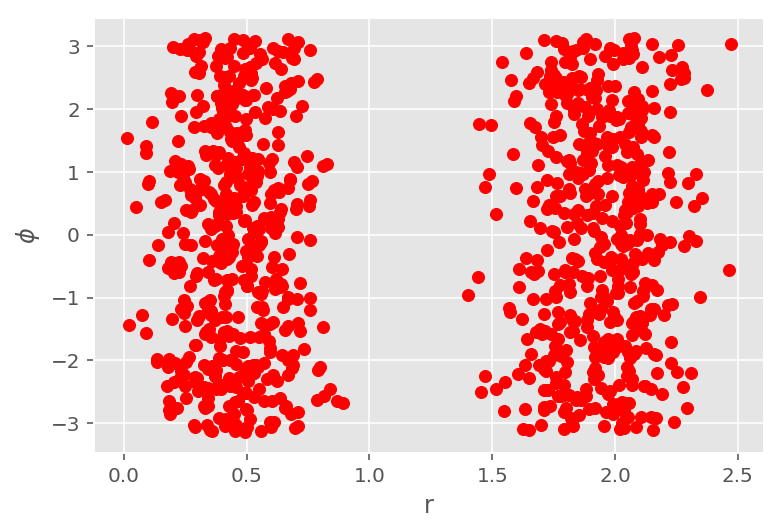

In [21]:
plt.scatter(r, phi, c='r')
plt.xlabel('r')
plt.ylabel(r'$\phi$')
plt.show()

### K-Means on data in polar coordinates

Silhouette Coefficient: 0.515
Estimated number of clusters: 2
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000


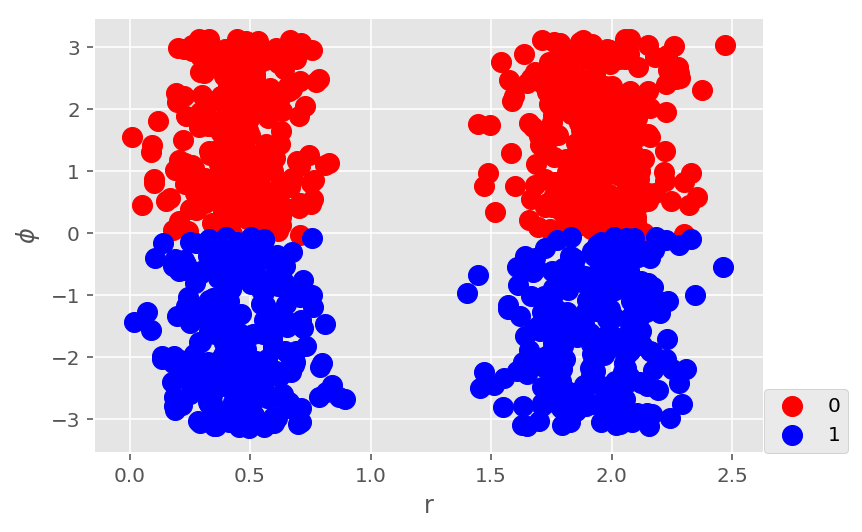

In [22]:
# specify initial cluster centers, otherwise the algorithm does
# not find good ones and does not succeed to separate
k_means = KMeans(n_clusters=2)
k_means.fit(X_new)
labels = k_means.labels_
cluster_score(X_new, circles_y, labels)

unique_labels = np.unique(labels)
colors = 'rbgymko'

for (label, color) in zip(unique_labels, colors):

    class_member_mask = (labels == label)
    n = X_new[class_member_mask, :]
    plt.scatter(n[:, 0], n[:, 1], c=color, s=100, label=label)

    plt.legend(loc=[1, 0])
    plt.xlabel('r')
    plt.ylabel(r'$\phi$')

/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Silhouette Coefficient: 0.226
Estimated number of clusters: 2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000


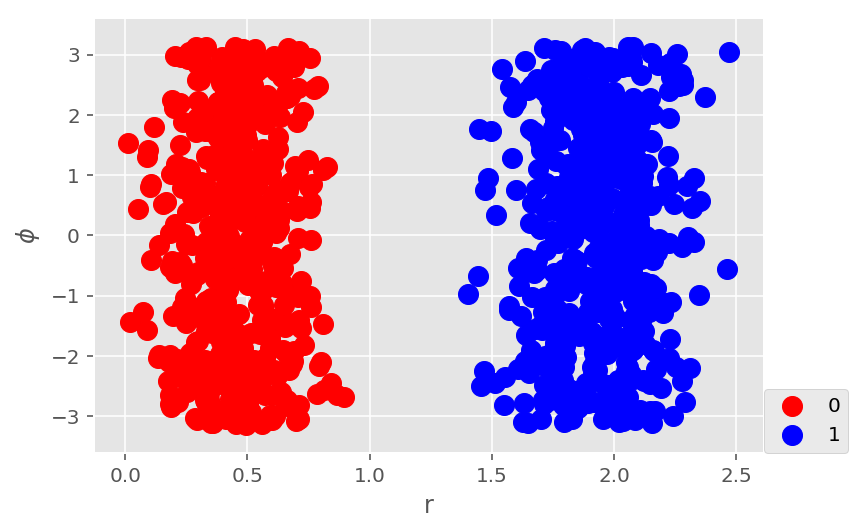

In [23]:
# specify initial cluster centers, otherwise the algorithm does
# not find good ones and does not succeed to separate
k_means = KMeans(n_clusters=2, init=np.array([[0,  0], [3, 0]]))
k_means.fit(X_new)
labels = k_means.labels_
cluster_score(X_new, circles_y, labels)

unique_labels = np.unique(labels)
colors = 'rbgymko'

for (label, color) in zip(unique_labels, colors):

    class_member_mask = (labels == label)
    n = X_new[class_member_mask, :]
    plt.scatter(n[:, 0], n[:, 1], c=color, s=100, label=label)

    plt.legend(loc=[1, 0])
    plt.xlabel('r')
    plt.ylabel(r'$\phi$')

### Hierarchical clustering on data in polar coordinates

Linkage:  complete
Silhouette Coefficient: 0.226
Estimated number of clusters: 2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000


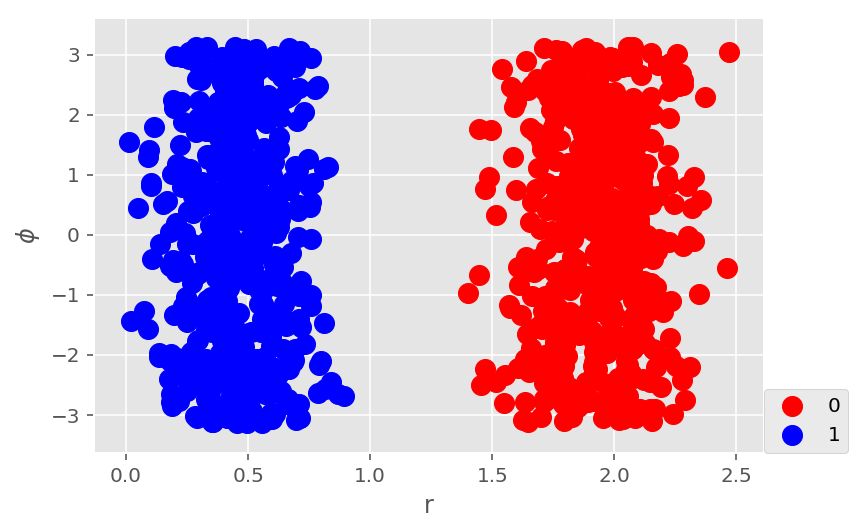

Linkage:  average
Silhouette Coefficient: 0.226
Estimated number of clusters: 2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000


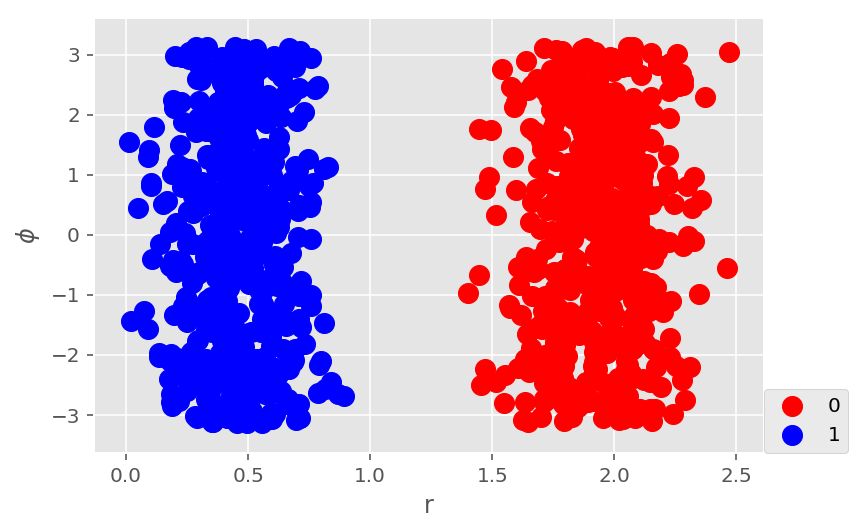

In [24]:
# for hierachical clustering, let's try the different linkage types
for linkage_type in [#'ward', 
                     'complete', 'average']:
    print('Linkage: ', linkage_type)
    agg = AgglomerativeClustering(n_clusters=2, linkage=linkage_type, 
                                  affinity='seuclidean')
    agg.fit(X_new)
    labels = agg.labels_
    cluster_score(X_new, circles_y, labels)
    unique_labels = np.unique(labels)
    colors = 'rbgymko'

    for (label, color) in zip(unique_labels, colors):

        class_member_mask = (labels == label)
        n = X_new[class_member_mask, :]
        plt.scatter(n[:, 0], n[:, 1], c=color, s=100, label=label)

        plt.legend(loc=[1, 0])
        plt.xlabel('r')
        plt.ylabel(r'$\phi$')
    plt.show()

In [25]:
# do the same with scipy
Z = linkage(X_new, 'average', metric='seuclidean')

c, coph_dists = cophenet(Z, pdist(X_new))

print(c)
print(len(coph_dists))
print(coph_dists.mean())

0.49538789221554186
499500
1.7982540044819226


In [26]:
clusters = fcluster(Z, 2, criterion='maxclust')
print(len(set(clusters)))

2


In [27]:
cluster_score(X_new, circles_y, clusters)

Silhouette Coefficient: 0.226
Estimated number of clusters: 2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000


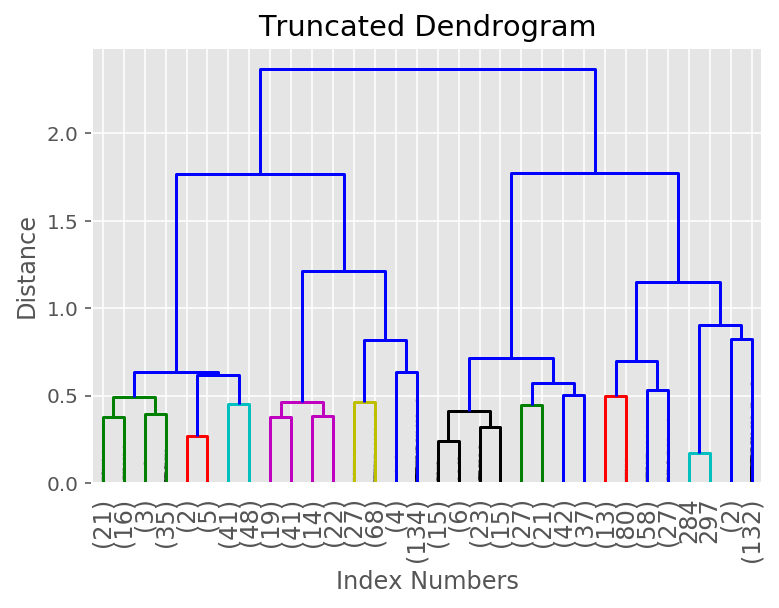

In [28]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='level',
    p=4,
    show_leaf_counts=True,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    color_threshold=0.5
)
plt.show()